# TensorFlow - Keras ile Lineer Olmayan Regresyon

"Lineer Regresyon ve Patlayan Gradyanlar" notebook'uma [buradan](https://github.com/Frightera/TensorFlow-2.X-Ogretici-Notebooklar/blob/main/1%20-%20Lineer%20Regresyon%20ve%20Patlayan%20Gradyanlar.ipynb) ulaşabilirsiniz.

In [1]:
# Importlar ile başlayalım

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.colors as colors # Plot ederken renkleri ayarlamak için

import numpy as np

print('TF version: ', tf.__version__) # 2.5.0

TF version:  2.5.0


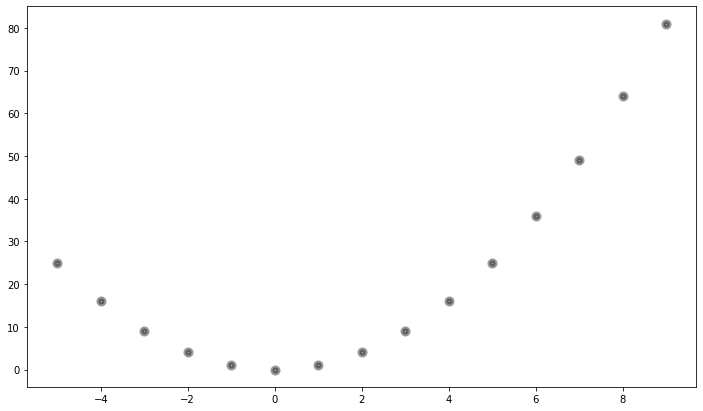

In [2]:
# İkinci dereceden polinom verisi oluşturalım.
# x'lerin karelerine karşılık y değerlerini tahmin etmeye çalışacağız.

# Yani modellemeye çalıştığımız ilişki ax^2 + bx + c

x = tf.constant(tf.range(-5, 10, dtype = tf.float32))
y = tf.constant(x.numpy() ** 2, dtype = tf.float32)

plt.figure(figsize = (12,7))
plt.scatter(x.numpy(), y.numpy(), linewidth = 4,
           alpha = 0.4, color = 'black')
plt.show()

In [3]:
# Sequential ile modelimizi oluşturup layer ekleyelim.
# HATIRLATMA: Sequential dışında Functional API ve Model Subclassing ile de model oluşturabiliriz.
# Sequential ile layerlar stack gibi üst üste olacaktır.

# Functional API ve Model Subclassing bize daha kompleks modeller oluşturma şansı tanır,
# Sequential ile bu mümkün değildir.

# Basit, lineer bir model ile başlayalım.
# Modelin lineer olmasının sebebi aktivasyon fonksiyonu **uygulanmamasıdır**.

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape = (1,))
])

# Mean squared error'u adam optimizer ile minimize edelim.
model.compile(loss = 'mse', optimizer = 'adam')

# 1000 epoch eğitelim.
model.fit(x.numpy(), y.numpy(), epochs = 1000, verbose = 0)
print('Training bitti')

test_sayisi = 20

# Model veriyi öğrenebildiyse sonuç 400'e yakın çıkmalı.
tahmin = model(tf.convert_to_tensor([[test_sayisi]]))
print('%d için model tahmini: %.3f' %(test_sayisi, tahmin))

Training bitti
20 için model tahmini: 27.613


Tahmin hiç yakın gözükmüyor. Plot ederek sorunu daha iyi görebiliriz.

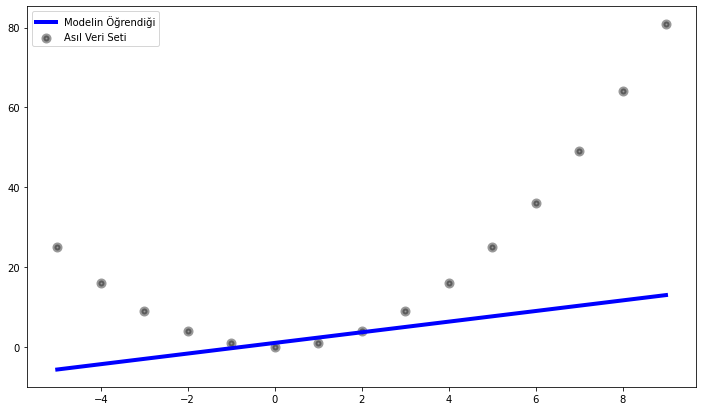

In [4]:
plt.figure(figsize = (12,7))

plt.scatter(x.numpy(), y.numpy(), linewidth = 4,
           alpha = 0.4, color = 'black', 
           label = 'Asıl Veri Seti')

plt.plot(x.numpy(), model.predict(x.numpy()), 
         label = 'Modelin Öğrendiği', color = 'blue',
         linewidth = 4)

plt.legend()
plt.show()

## Problem

Buradaki sorun, modelin tamamen lineer fonksiyonları öğrenebilecek olmasıdır. Bunu çizdirdiğimiz plottan da görebiliyoruz. Model, lineer olmayan ilişkileri öğrenemiyor. Çünkü dense layer çıktısına hiçbir **aktivasyon fonksiyonu uygulamadık**. 

Bir dense layer aslında şu eşitliği hesaplıyor: $Aktivasyon(W \cdot x + b)$. Burada bir aktivasyon vermediğimiz zaman lineer eşitlikleri hesaplayabilecek bir layer olarak kalıyor. Bu problemi çözmek için aktivasyon fonksiyonu kullanmamız gerekiyor.

Yaygın olan aktivasyon fonksiyonlarına bakacak olursak:

* Sigmoid
* ReLU
* Softmax
* Tanh
* Leaky ReLU
* Swish - SiLU

gibi sıralanabilir.

## Sigmoid Aktivasyon Fonksiyonu

* Sigmoid aktivasyonu çoğu zaman modellerin çıktı veren layerlarında kullanılır. Çünkü değeri 0 ve 1 arasındadır. Bu da model çıktısını bir olasılık(probability) gibi yorumlamamızı sağlıyor. 

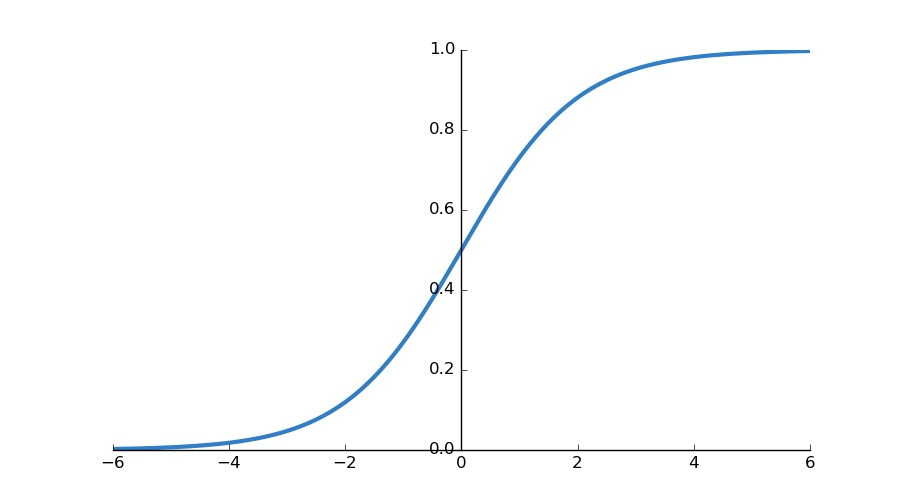

* Hidden layerlarda sigmoid aktivasyonu tercih edilmez çünkü **vanishing gradient** - **kaybolan gradyan** problemine sebep olurlar.


### Vanishing Gradients Nedir? 

Kaybolan Gradyan Problemi, Deep Learning gibi gradyan tabanlı yöntemlerle (örneğin Geri Yayılım) eğitilen modellerin eğitimi sırasında karşılaşılan bir zorluktur. Bu problem, modeldeki önceki katmanların parametrelerini öğrenmesini ve ayarlamasını zorlaştırıyor. Modeldeki katman(layer) sayısı arttıkça bu sorun daha da problematik hale gelir.

Bu aslında Deep Learning tabanlı bir sorun değildir. Yukarıda da belirttiğim gibi gradyan tabanlı öğrenmedeki aktivasyon fonksiyonlarının sonucunda ortaya çıkan bir durumdur.

#### Neden Olur?

Kaybolan gradyan problemi, aktivasyon fonksiyonunun seçimine bağlıdır. Birçok yaygın aktivasyon fonksiyonu (örneğin sigmoid veya tanh) girdilerini çok küçük bir çıktı aralığına çok doğrusal olmayan bir şekilde 'bastırır-sıkıştırır'. Örneğin, sigmoid, gerçek sayı doğrusunu [0, 1] aralığına eşler. Yani [0,1] arası değerler alır.

Bu tür doğrusal olmayan birden çok katmanı(modeldeki layerlar aktivasyon fonksiyonları alınca lineer olmaktan çıkarlar) üst üste yığdığımızda bu problem ortaya çıkmaya başlar. Örneğin, birinci katman, büyük bir girdi bölgesini daha küçük bir çıktı bölgesine eşler, bu ikinci katman tarafından daha da küçük bir bölgeye eşlenir, üçüncü katman tarafından daha da küçük bir bölgeye eşlenir. Sonuç olarak, ilk katmanın parametrelerinde büyük bir değişiklik bile çıktıyı fazla değiştirmez.


#### Çözümü Nedir?
Gelen değerleri küçük bir bölgeye 'bastırma-sıkıştırma' özelliğine sahip olmayan aktivasyon fonksiyonlarını kullanarak bu problemden kaçınabiliriz. Popüler bir seçim, girdiyi `max(0,girdi)`'ye eşleyen ReLU fonksiyonudur(Rectified Linear Unit).

* Random değerler oluşturup sigmoid'e verecek olursak:
```
<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.6335894 , 0.6718202 , 0.50073737, 0.68625426, 0.5716209 ,
        0.5749835 , 0.5452308 , 0.566044  , 0.66506517, 0.57409763,
        0.635278  , 0.57984906, 0.6798589 , 0.5836538 , 0.68950236,
        0.66081023, 0.5210986 , 0.66980314, 0.6656562 , 0.56527734,
        0.69850767, 0.5981427 , 0.61163193, 0.65284   , 0.5069695 ,
        0.6343662 , 0.70734084, 0.6234243 , 0.71751976, 0.53370357,
        0.5370744 , 0.67167205]], dtype=float32)>
```

## ReLU (Rectified Linear Unit)
* ReLU fonksiyonu yukarda bahsettiğim probleme çözüm olmaktadır. Günümüzde en çok kullanılan aktivasyon fonksiyonlarından biridir. Grafiğine bakacak olursak:
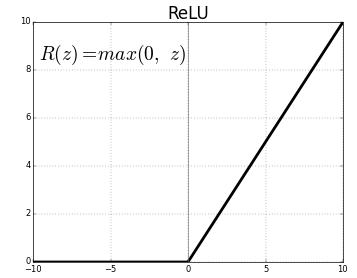

* Ancak sorun şu ki, tüm negatif değerler anında sıfır olur. Bu da modelin verileri uygun şekilde modellemesi yeteneğini azaltır. Yani diğer bir şekilde demek gerekirse, ReLU aktivasyonuna verilen herhangi bir negatif değer hemen sıfıra çevrilir.

### Dying ReLU - Ölen ReLU
* ReLU'nun negatif değerlerde verdiği çıktının sıfır olduğunu söylemiştim. Bu da negatif değerlerin türevlerinin sıfır olması anlamına geliyor. Eğer modelimizdeki ağırlıklar(weights) ReLU aktivasyonuna girip negatif değerler veriyor ise, o ağırlıklar modelin eğitimine etkili bir şekilde katkıda bulunmaz. 

* Matematiksel olarak, o nörondan gelen ağırlığın(weight) güncellemelere gradyan katkısı yoktur ve sıfırdır.


* Yukarda sigmoid'e verdiğimiz değerleri ReLU'ya verirsek:
```
<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.5476464 , 0.71642923, 0.00294948, 0.78266525, 0.2884674 ,
        0.3022132 , 0.18141913, 0.26572847, 0.68594897, 0.29858923,
        0.55492723, 0.32215393, 0.75312364, 0.33779085, 0.79779387,
        0.6669072 , 0.08444452, 0.7072948 , 0.68860364, 0.2626083 ,
        0.84020174, 0.39773226, 0.45417726, 0.63154626, 0.02787995,
        0.55099416, 0.88250387, 0.5041082 , 0.9321917 , 0.13501906,
        0.1485703 , 0.71575725]], dtype=float32)>
```

## Leaky ReLU
* Ölen ReLU problemine çözüm olması için geliştirilmiştir. Gelen negatif değerleri ReLU aktivasyonunda olduğu gibi direkt 0 olarak tanımlamak yerine, gelen değerleri x'in son derece küçük doğrusal bir bileşeni olarak tanımlarız.

* Grafiğine bakacak olursak:
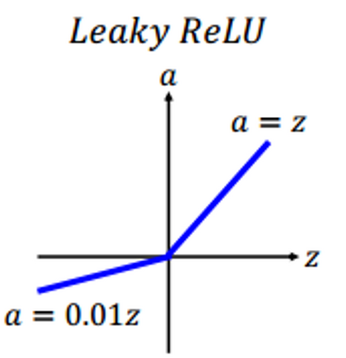

* $f(x)=max(0.01*x , x).$: Bu fonksiyon, herhangi bir pozitif girdi alırsa girdinin kendisini döndürür. Ancak herhangi bir negatif girdi değeri için: 

$(0.01 * girdi)$ *(0.01 değiştirebilir)* olan küçük bir değer döndürür.

* ReLU'nun aksine negatif değerler için sıfır harici bir çıktı verir. Bu küçük değişiklik ile grafiğin sol tarafının gradyanının değerini sıfır olmayan bir değerle değiştirmiş oluyor. 

* Bu şekilde Ölen ReLU - Dying ReLU problemine çözüm olmuş olur.

## Swish - SiLU
* Bu aktivasyon Google Brain tarafından önerilmiştir. Matematiksel olarak $x · sigmoid(x)$ olarak ifade edebiliriz. Google Brain, yapılan deneylerde bu aktivasyonun zorlu datasetlerde ReLU'dan daha iyi performans gösterdiğini belirtmiştir. Grafiğine bakacak olursak:

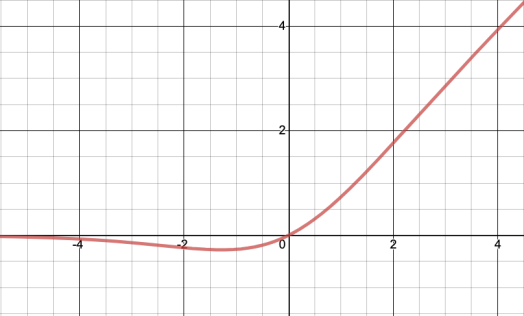

* Aynı random değerleri Swish'e verirsek:
```
<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.34698296, 0.48131165, 0.00147691, 0.53710735, 0.164894  ,
        0.1737676 , 0.0989153 , 0.150414  , 0.45620078, 0.17141937,
        0.35253304, 0.18680066, 0.51201785, 0.19715291, 0.5500808 ,
        0.4406991 , 0.04400392, 0.4737483 , 0.45837328, 0.14844652,
        0.58688736, 0.23790064, 0.27778932, 0.41229868, 0.01413429,
        0.34953207, 0.62423104, 0.3142733 , 0.668866  , 0.07206015,
        0.0797933 , 0.48075414]], dtype=float32)>
```


## Softmax
* Hidden layerlarda kullanılmayan bir aktivasyondur(istisnalar hariç - attention gibi.). Multiclass sınıflandırma yapıldığında çıktı katmanında kullanılır. Çıktı katmanında kullanılmasının sebebi, baskın olan nöronların ortaya çıkmasını sağlamaktır. Aktivasyon uygulanan çıktıların toplamı 1 olacaktır. Bu sebepten ötürü de çıktıları olasılık gibi düşünebiliriz.

* Dediğim gibi, verilen girdilerin toplamını 1 olacak şekilde geri döndürür. Yani nöronlar **lineer olarak bağımlı** hale gelir. Hidden layerlarda kullanılmaz dememin en büyük sebebi lineer bağımlılıktır ve bu da modelin genelleme yeteneğini olumsuz etkiler. Nöronların lineer olarak birbirlerinden bağımsız olmasını isteriz.

* **Örnek**: 
```
<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.03219971, 0.03812005, 0.0186764 , 0.04073047, 0.02484803,
        0.02519195, 0.02232552, 0.02428939, 0.03697567, 0.02510082,
        0.03243501, 0.02569934, 0.03954482, 0.02610435, 0.04135135,
        0.03627825, 0.02026217, 0.03777343, 0.03707396, 0.02421372,
        0.04314269, 0.02771693, 0.02932641, 0.03501783, 0.01914786,
        0.0323077 , 0.04500687, 0.03082788, 0.04729965, 0.02131328,
        0.02160407, 0.03809445]], dtype=float32)>
```

* Softmax'in neden hidden layerlarda kullanılmadığını daha iyi görmüş olduk. ReLU ve diğerlerinde değerler birbirlerinden bağımsızdı ve alabileceği değerler aralığı genişti. Softmax kullanınca hepsi birbirine lineer bağımlı olmuş oldu.

## TensorFlow ile Aktivasyon Fonksiyonları

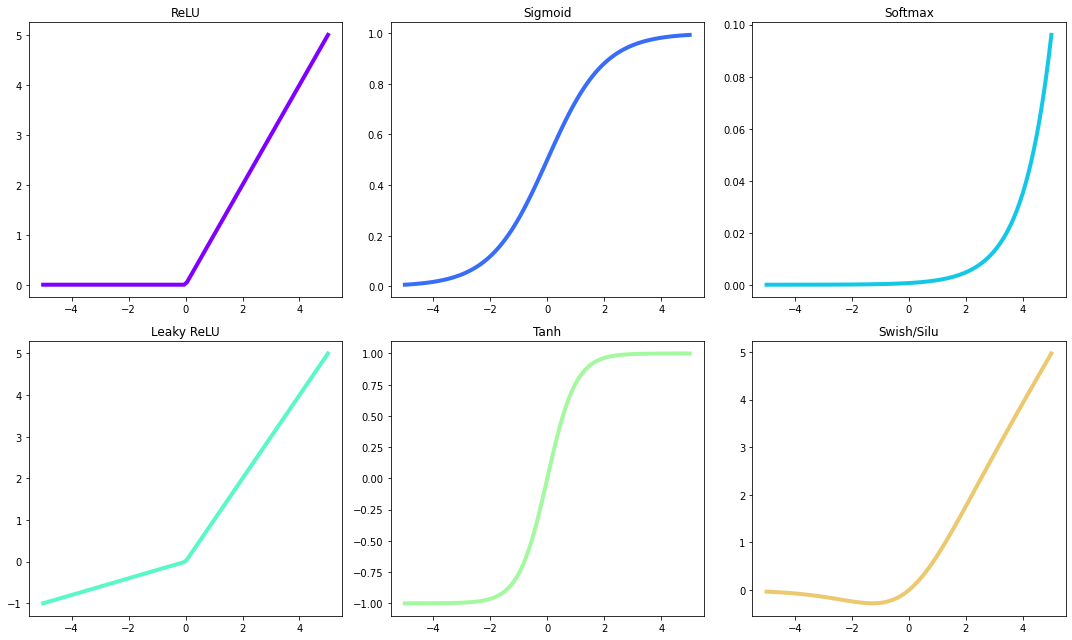

In [5]:
import matplotlib.cm as cm

renk_array = cm.rainbow(np.linspace(0, 2, 15))
renkler = [colors.rgb2hex(i) for i in renk_array]

# Örnek veri oluşturma
X = np.linspace(-5,5,100) # -5 ve 5 arasında 100 tane sayı içerir.

# TensorFlow'un NN için operasyonları bulunur. tf.nn çatısı altında erişilebilir.

y_relu = tf.nn.relu(X) # ReLU aktivasyonu
y_sigmoid = tf.nn.sigmoid(X) # Sigmoid aktivasyonu
y_softmax = tf.nn.softmax(X) # Softmax aktivasyonu
y_leaky_relu = tf.nn.leaky_relu(X) # Leaky_ReLU aktivasyonu
y_tanh = tf.nn.tanh(X) # Tanh aktivasyonu
y_swish = tf.nn.silu(X) # SiLU/Swish aktivasyonu

# Aktivasyonları yan yana görselleştirmek için subplots kullanalım.
fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel() # döngüde shape sorunu olmasın diye.

list_plot = [y_relu, y_sigmoid, y_softmax, 
             y_leaky_relu, y_tanh, y_swish]

list_baslik = ['ReLU', 'Sigmoid', 'Softmax',
              'Leaky ReLU', 'Tanh', 'Swish/Silu']

for i in range(len(list_plot)):
    axs[i].plot(X, list_plot[i], color = renkler[i], linewidth = 4)
    axs[i].set_title(list_baslik[i])
    fig.tight_layout()

Aktivasyon ReLU, 20 sayısı için tahmin: 174.733

Aktivasyon Sigmoid, 20 sayısı için tahmin: 21.675

Aktivasyon Softmax, 20 sayısı için tahmin: 2.584

Aktivasyon Leaky ReLU, 20 sayısı için tahmin: 199.150

Aktivasyon Tanh, 20 sayısı için tahmin: 36.071

Aktivasyon Swish/Silu, 20 sayısı için tahmin: 212.436



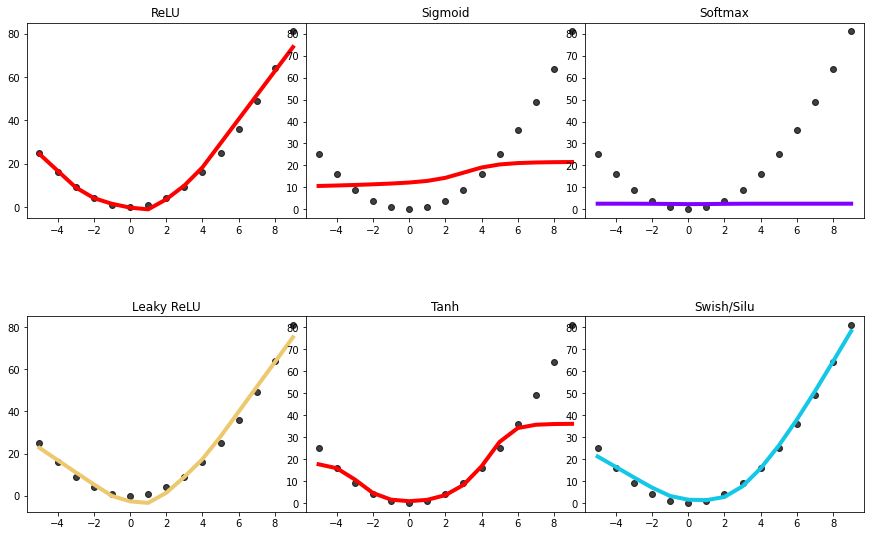

In [9]:
# Aynı subplots mantığını aktivasyonları modele ekleyerek kullanalım.

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

aktivasyonlar = [tf.nn.relu, tf.nn.sigmoid, tf.nn.softmax,
                tf.nn.leaky_relu, tf.nn.tanh, tf.nn.silu]

for index, each in enumerate(aktivasyonlar):
    tf.keras.backend.clear_session() # Döngü içinde model define ettiğimiz için
    model = tf.keras.Sequential([
        # Döngü boyunca listedeki aktivasyonları test edeceğiz.
        
        # Modele daha fazla dense layer ekleyerek veriyi daha iyi kavramasını sağlayabiliriz.
        # Bunu yaparken her layera bir aktivasyon tanımlayacağız.
        
        # NOT: Model kompleks hale geldikçe her zaman daha iyi sonuç verecek diye bir kural yoktur.
        
        # Her x'e karşılık bir y olduğu için input_shape = (1,)
        tf.keras.layers.Dense(64, input_shape = (1,), activation = each),
        tf.keras.layers.Dense(32, activation = each),
        tf.keras.layers.Dense(1) # Son katmanda bir aktivasyon olmamasının sebebi, regresyon yapıyor oluşumuz.
        # Bu regresyonda modelin çıktı vereceği sayıyı direkt olarak almak istiyorum. Ondan son layerı olduğu 
        # gibi bıraktık.
    ])

    # Mean squared error'u adam optimizer ile minimize edelim.
    model.compile(loss = 'mse', optimizer = 'adam')

    # 1000 epoch eğitelim.
    model.fit(x.numpy(), y.numpy(), epochs = 1000, verbose = 0)
    
    tahmin_sayisi = np.expand_dims(np.array([20]), axis = 0)
    
    """
    Neden np.expand_dims() kullandık?
    >> np.array([20]).shape yaparsanız, çıktı olarak (1,) alacaksınız. 
    >> Biz modeli eğitirken batch kullanarak eğitim gerçekleştiriyoruz. Yani model ayrıca
    >> batch sayısını biliyor.
   
    >> model.summary() bakacak olursak:
    Layer (type)                 Output Shape              Param #   
    =================================================================
    dense (Dense)                (None, 64)                128       
    _________________________________________________________________
    dense_1 (Dense)              (None, 32)                2080      
    _________________________________________________________________
    dense_2 (Dense)              (None, 1)                 33        
    =================================================================
    >> Output shape'de bulunan **None** batch size'a denk geliyor. None demek her türlü batch_size'ı model
    >> kabul edebilir demek.
    
    >> Modeli eğitirken batch kullandığımız modelin beklediği input'un shape'i (1,1) olmalı.
    >> 0.indisteki 1 kaç tane örnek vereceğimizi söylüyor. Yani expand_dims yapmadan modele bunu
    >> predict et diyemezdik.
    
    """
    tahmin = model(tahmin_sayisi)
    
    print('Aktivasyon %s, 20 sayısı için tahmin: %.3f\n' %(list_baslik[index], tahmin))
    
    axs[index].plot(x.numpy(), model.predict(x.numpy()), color = np.random.choice(renkler),
                   linewidth = 4)
    axs[index].scatter(x.numpy(), y.numpy(), color = 'black', alpha = 0.75)
    
    axs[index].set_title(list_baslik[index])
    
    del model

## Ezberin Dışına Çıkmak - Layer Subclassing
* Bu problemi daha farklı nasıl çözebilirdik? Bunun bir yolu da kendimize özel layer oluşturmaktır. Normal bir dense layer $Aktivasyon(Wx + b)$ hesapladığı için lineer olmayan ilişkiyi öğrenmesi için aktivasyon uyguladık.


* Kendimiz bir layer class'ı yazarak $ax^2 + bx + c$ ilişkisini aktivasyon kullanmadan modelleyebilir miyiz? Evet, bunu yapabiliriz. İsmine de **Layer Subclassing** deniyor.

In [7]:
class KareLayer(tf.keras.layers.Layer): # Inheritance - Base Class
    # Native TensorFlow fonksiyonları kullanılmalıdır.
    
    def __init__(self, units=32):
        # Sınıfın değişkenlerini set up eder
        
        super(KareLayer, self).__init__() 
        
        self.units = units  
    
    def build(self, input_shape):
        # Layerın weightlerini oluşturacağımız yer.
        
        # GlorotUniform: Varsayılan olarak layerlarda kullanılan, weightleri random init. etme fonksiyonu. (Xavier init.)
        # Önceki layerdan gelecek inputları kullanacağı için input_shape[-1] diyoruz.
        # Trainable: True olursa bu layer eğitim sırasında öğrenme sürecine dahil edilir. (Backprop)
        # dtype: Layerın ağırlıklarının olacağı veri tipi. (TensorFlow en iyi float32'de çalışır)
        
        initializer_1 = tf.keras.initializers.GlorotUniform()
        a_initiliazer = initializer_1(shape = (input_shape[-1], 
                                               self.units), 
                                               dtype = tf.float32)
        self.a = tf.Variable(name = 'a', initial_value = a_initiliazer, trainable = True)
        
        
        initializer_2 = tf.keras.initializers.GlorotUniform()
        b_initiliazer = initializer_2(shape = (input_shape[-1], 
                                               self.units), 
                                               dtype = tf.float32) 
        
        self.b = tf.Variable(name = 'b', initial_value = b_initiliazer, trainable = True) 
        
        initializer_3 = tf.keras.initializers.Zeros()
        c_initializer = initializer_3(shape = (self.units,), 
                                      dtype = tf.float32)
        
        # Bias terimi
        # Biasları sıfırlar ile başlatmakta bir sorun yoktur. Bu yaygın bir kullanımdır.
        # Weightleri sıfırdan başlatsaydık hepsinin türevi sıfır olacaktı ve hepsi AYNI özelliği
        # öğrenecekti. 
        self.c = tf.Variable(name = 'bias', initial_value = c_initializer, trainable = True)

        
    def call(self, inputs):
        # Computation Graph'ın kurulduğu fonksiyondur. Yapılacak hesaplamaları tanımlar.
        # Normal şekilde python print() fonksiyonu burada çalışmaz. print() ile istenilen çıktıyı alamazsınız.
        # TensorFlow computation graph'ı kurmak için bu layerı 1 kere çağırır(call).
        # Bir değeri öğrenmek için normal print() yerine tf.print() kullanılmalıdır.
        
        # Eğer burada TF yerine numpy kullanıp aşağıda verileni hesaplasaydık, modeli fit 
        # ederken **Gradients do not exist for variables** gibi bir uyarı alacaktık.
        # Bunun sebebi TensorFlow'un kendisi dışındaki fonksiyonları kullanarak nasıl 
        # backpropagation yapacağını bilmemesidir.
        
        return tf.matmul(tf.math.square(inputs), self.a) +  tf.matmul(inputs, self.b) + self.c

Training bitti
20 için model tahmini: 397.814


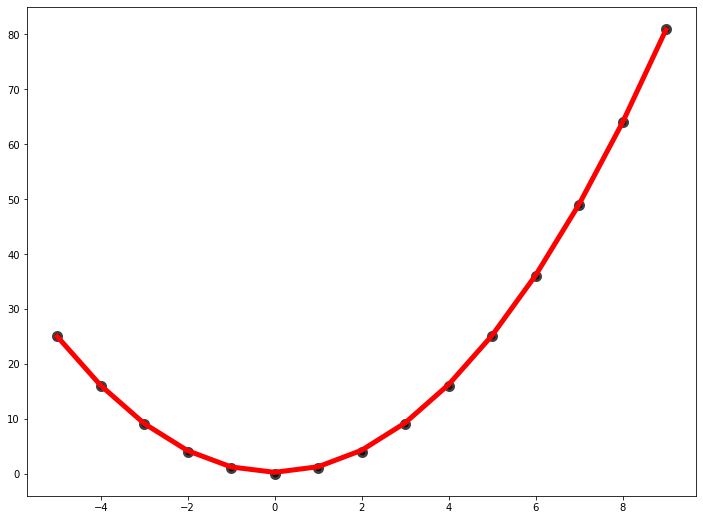

In [8]:
# Sequential ile aynı şekilde modeli oluşturalım.
model = tf.keras.Sequential([
    KareLayer(32), # Kendi layerımızdan bir tane ekleyelim.
    tf.keras.layers.Dense(1)
])

# Mean squared error'u adam optimizer ile minimize edelim.
model.compile(loss = 'mse', optimizer = 'adam')

# 1000 epoch eğitelim.
model.fit(x.numpy(), y.numpy(), epochs = 1000, verbose = 0)
print('Training bitti')

test_sayisi = 20

# Model veriyi öğrenebildiyse sonuç 400'e yakın çıkmalı.
tahmin = model(tf.convert_to_tensor([[test_sayisi]]))
print('%d için model tahmini: %.3f' %(test_sayisi, tahmin))

plt.figure(figsize = (12,9))
plt.plot(x.numpy(), model.predict(x.numpy()), color = np.random.choice(renkler),
        linewidth = 5)
plt.scatter(x.numpy(), y.numpy(), color = 'black', linewidth = 5, alpha = 0.75)
plt.show()